Resnet34 model as proposed here: https://arxiv.org/pdf/1612.02903v1.pdf


Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git lfs install
!git clone https://github.com/WiktorPieklik/Facial-Expression-Recognition.git
!cd /content/Facial-Expression-Recognition && git checkout custom-net

In [3]:
!python /content/Facial-Expression-Recognition/install.py

In [ ]:
!cd /content/Facial-Expression-Recognition && python /content/Facial-Expression-Recognition/setup_dataset.py

In [ ]:
# !cp -r "/content/drive/My Drive/TAI/II/Neural-networks/data/" "/content/sample_data/fer"

In [5]:
import os
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa

import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Debbuging options

In [ ]:
# uncomment to log device placement of each operation
# tf.debugging.set_log_device_placement(True)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

Num GPUs Available:  1


## Parameters

In [9]:
IMG_SIZE=(48,48)
INPUT_SHAPE=IMG_SIZE + (1,)

# Choose resize method. The options are:
# area, bicubic, bilinear, gaussian, lanczos3, lanczos5, mitchellcubic, nearest
INTERPOLATION = "bilinear"

BATCH_SIZE=128
MAX_EPOCHS = 300
NUM_CLASSES=7
CLASS_WEIGHTS= {0: 1, 1: 1}
CLASS_NAMES=[]


SEED=1234

Paths

In [10]:
# # choose data directory
TRAIN_DATA_PATH=Path('/content/Facial-Expression-Recognition/raw/images/Training')
VAL_DATA_PATH=Path('/content/Facial-Expression-Recognition/raw/images/PublicTest')
TEST_DATA_PATH=Path('/content/Facial-Expression-Recognition/raw/images/PrivateTest')
# choose logs directory
LOG_DIR = Path('/content/drive/My Drive/TAI/II/Neural-networks/notebooks/logs')

In [11]:
# name your experiment
EXPERIMENT = "Facial-Expression-Recognition-with-Resnet34"

In [12]:
OUTPUT_DIR = LOG_DIR / EXPERIMENT / 'trial_{:02}'
counter=1
while os.path.exists(str(OUTPUT_DIR).format(counter)):
    counter += 1
OUTPUT_DIR = Path(str(OUTPUT_DIR).format(counter))
os.makedirs(OUTPUT_DIR, exist_ok = True)

In [25]:
summary_filepath = OUTPUT_DIR / 'model.txt'
best_model_filepath = OUTPUT_DIR / f'model.h5'
csv_logger_filepath = OUTPUT_DIR / f'training.log'
history_filepath = OUTPUT_DIR / f'training_history.png'
report_filepath = OUTPUT_DIR / 'report.txt'
confusion_matrix_norm_filepath = OUTPUT_DIR / f'confusion_matrix_norm.png'
confusion_matrix_filepath = OUTPUT_DIR / f'confusion_matrix.png'

## DATA INPUT PIPELINE

Load datasets

In [14]:
from keras.preprocessing.image import ImageDataGenerator


train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DATA_PATH,
        color_mode='grayscale',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DATA_PATH,
        color_mode='grayscale',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False)

test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DATA_PATH,
        color_mode='grayscale',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False)

class_names = train_ds.class_names

Found 28709 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.


In [62]:
# labels = [np.argmax(y) for x, y in train_ds]
# neg, pos = np.bincount(labels)
# total = neg + pos

# # Scaling by total/2 helps keep the loss to a similar magnitude.
# # The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)


# CLASS_WEIGHTS = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

Show images

In [63]:
# for _ in range(5):
#     img, label = train_ds.next()
#     print(img.shape)   #  (1,256,256,3)
#     plt.imshow(img[0][:,:,0], cmap="gray")
#     plt.show()

##### Build model

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras.activations import relu
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x
    
rescale = tf.keras.layers.Rescaling(1./255)
def ResNet34(shape = (48, 48, 1), classes = 7):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = rescale(x_input)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

model = ResNet34()
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 27, 27, 64)   3200        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 27, 27, 64)  256         ['conv2d_1[0][0]']        

Save model summary

In [17]:
with open(summary_filepath, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Compile model

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
              metrics=['accuracy'])

Pre-evaluate model

In [19]:
model.evaluate(test_ds)

29/29 [==============================] - 9s 59ms/step - loss: 21.8745 - accuracy: 0.1248


[21.874462127685547, 0.1248258575797081]

Callbacks

In [20]:
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=best_model_filepath)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
csv_logger = tf.keras.callbacks.CSVLogger(filename=csv_logger_filepath)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=OUTPUT_DIR)


def schedule(epoch) -> float:
    if epoch >= 5:
        return 0.00005
    return 0.0005
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)


##### Training

In [21]:
history = model.fit(
        train_ds,
        epochs=MAX_EPOCHS,
        validation_data=val_ds,
        callbacks=[save_checkpoint, csv_logger, reduce_lr, early_stop],
        # class_weight=CLASS_WEIGHTS,
        workers=10,
        # use_multiprocessing=True
    )

Epoch 1/300
225/225 [==============================] - 26s 91ms/step - loss: 1.9790 - accuracy: 0.2482 - val_loss: 1.8047 - val_accuracy: 0.2630 - lr: 0.1000
Epoch 2/300
225/225 [==============================] - 23s 99ms/step - loss: 1.7456 - accuracy: 0.2848 - val_loss: 1.8108 - val_accuracy: 0.2920 - lr: 0.1000
Epoch 3/300
225/225 [==============================] - 26s 116ms/step - loss: 1.6284 - accuracy: 0.3519 - val_loss: 1.7304 - val_accuracy: 0.3252 - lr: 0.1000
Epoch 4/300
225/225 [==============================] - 25s 107ms/step - loss: 1.5463 - accuracy: 0.3897 - val_loss: 1.5920 - val_accuracy: 0.3695 - lr: 0.1000
Epoch 5/300
225/225 [==============================] - 28s 122ms/step - loss: 1.4801 - accuracy: 0.4195 - val_loss: 1.5309 - val_accuracy: 0.4126 - lr: 0.1000
Epoch 6/300
225/225 [==============================] - 25s 107ms/step - loss: 1.4316 - accuracy: 0.4422 - val_loss: 1.8832 - val_accuracy: 0.3430 - lr: 0.1000
Epoch 7/300
225/225 [===========================

Evaluate model

In [22]:
# uncomment to load best model
# model=tf.keras.models.load_model(best_model_filepath)

model.evaluate(test_ds)

29/29 [==============================] - 3s 93ms/step - loss: 3.2372 - accuracy: 0.5667


[3.237187623977661, 0.5667316913604736]

### VISUALIZATION

Loss and accuracy history

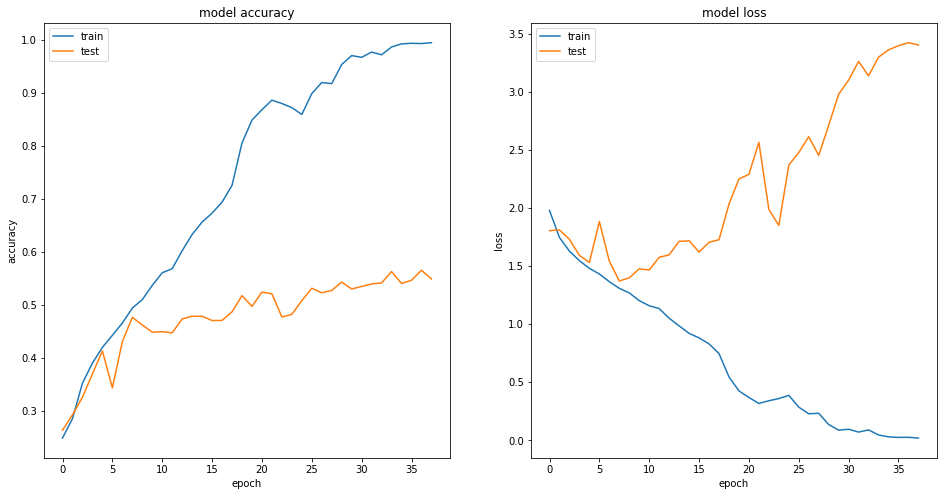

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig(history_filepath, facecolor='white', bbox_inches='tight')
plt.show()

Trues and predictions

29/29 [==============================] - 2s 73ms/step


<Figure size 432x288 with 0 Axes>

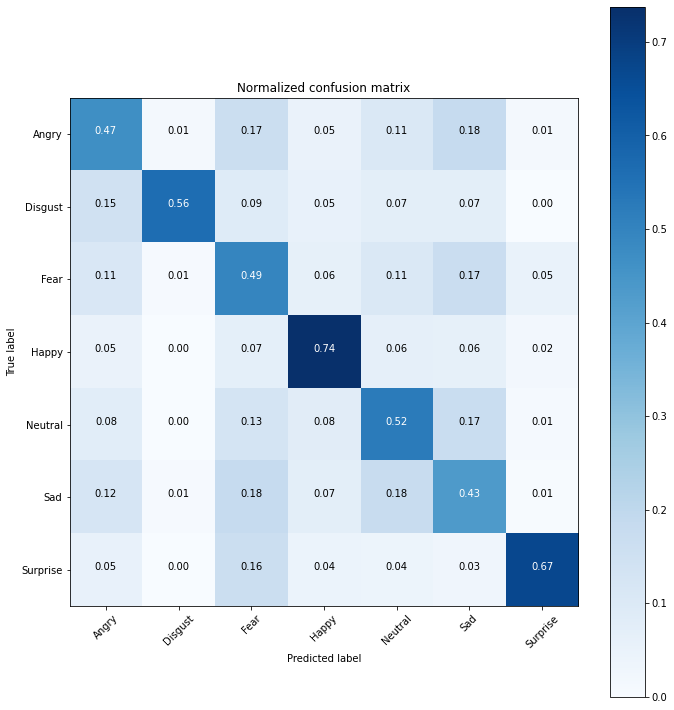

<Figure size 432x288 with 0 Axes>

In [33]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(test_ds)
preds = [np.argmax(probas) for probas in predictions]
trues = np.concatenate([y for x, y in test_ds], axis=0)
trues = [np.argmax(t) for t in trues]
class_names = test_ds.class_names

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(trues, preds)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()
plt.savefig(confusion_matrix_norm_filepath, facecolor='white', bbox_inches='tight')

Classification report

In [34]:
cr=classification_report(trues,preds,target_names=class_names)
cm = np.array2string(confusion_matrix(trues, preds))
with open(report_filepath, 'w') as f:
    f.write(f'Title\n\nClassification Report\n\n{cr}\n\nConfusion Matrix\n\n{cm}\n')

print(cr)

              precision    recall  f1-score   support

       Angry       0.48      0.47      0.47       491
     Disgust       0.63      0.56      0.60        55
        Fear       0.39      0.49      0.44       528
       Happy       0.79      0.74      0.76       879
     Neutral       0.53      0.52      0.53       626
         Sad       0.42      0.43      0.43       594
    Surprise       0.82      0.67      0.74       416

    accuracy                           0.57      3589
   macro avg       0.58      0.56      0.57      3589
weighted avg       0.58      0.57      0.57      3589



Confusion matrix

<Figure size 720x720 with 0 Axes>

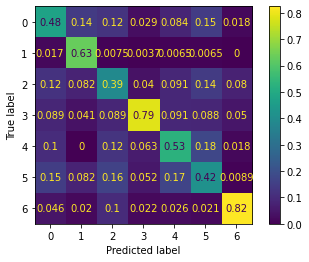

In [35]:
cm=confusion_matrix(trues, preds, normalize='pred')
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.savefig(confusion_matrix_filepath, facecolor='white', bbox_inches='tight')